In [ ]:
!pip install gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 MB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.1/322.1 kB 16.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.9/94.9 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.2/11.2 MB 47.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 5.8 MB/s eta 0:00:00
  Attempting uninstall: markupsafe
    Found existing installation: MarkupSafe 3.0.2
    Uninstalling MarkupSafe-3.0.2:
      Successfully uninstalled MarkupSafe-3.0.2


In [ ]:
import torch
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import DataLoader, random_split
from torchvision.models import vit_b_16
import torch.nn as nn
import torch.optim as optim
from google.colab import drive
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import cv2
import gradio as gr
from PIL import Image
import pandas as pd

In [ ]:
# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data_dir = "/content/drive/MyDrive/Colab Notebooks/Dataset/datasetstrobel"

In [ ]:
# Cek apakah GPU tersedia
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [ ]:
# 1️⃣ Data Preparation
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ColorJitter(brightness=0.3),  # Hanya brightness
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

In [ ]:
dataset = datasets.ImageFolder(root=os.path.join(data_dir), transform=transform)

In [ ]:
# Split dataset into train, validation, and test sets
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_data, val_data, test_data = random_split(dataset, [train_size, val_size, test_size])

In [ ]:
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

In [ ]:
# 2️⃣ Model Setup
model = vit_b_16(pretrained=True)
model.heads = nn.Linear(768, 2)  # Output 2 kelas: baik & buruk
model = model.to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:01<00:00, 181MB/s]


In [ ]:
# 3️⃣ Training Setup
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-4)

def train_model(model, train_loader, val_loader, epochs=10):
    for epoch in range(epochs):
        model.train()
        total_loss, correct = 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            correct += (outputs.argmax(1) == labels).sum().item()

        train_acc = correct / len(train_loader.dataset)
        val_acc = evaluate_model(model, val_loader)
        print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")


In [ ]:
def evaluate_model(model, data_loader):
    model.eval()
    correct = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds = outputs.argmax(1)
            correct += (preds == labels).sum().item()
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=dataset.classes))

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(6,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=dataset.classes, yticklabels=dataset.classes)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

    return correct / len(data_loader.dataset)

In [ ]:
# 4️⃣ Train the Model
train_model(model, train_loader, val_loader, epochs=20)

Epoch 1/20, Loss: 3.5650, Train Acc: 0.5856, Val Acc: 0.5385
Epoch 2/20, Loss: 2.6734, Train Acc: 0.5856, Val Acc: 0.6923
Epoch 3/20, Loss: 2.1011, Train Acc: 0.7027, Val Acc: 0.7692
Epoch 4/20, Loss: 1.1241, Train Acc: 0.8288, Val Acc: 0.8462
Epoch 5/20, Loss: 0.4798, Train Acc: 0.9640, Val Acc: 0.9231
Epoch 6/20, Loss: 0.3123, Train Acc: 0.9640, Val Acc: 1.0000
Epoch 7/20, Loss: 0.1730, Train Acc: 0.9820, Val Acc: 1.0000
Epoch 8/20, Loss: 0.0160, Train Acc: 1.0000, Val Acc: 1.0000
Epoch 9/20, Loss: 0.0115, Train Acc: 1.0000, Val Acc: 1.0000
Epoch 10/20, Loss: 0.0631, Train Acc: 1.0000, Val Acc: 1.0000
Epoch 11/20, Loss: 0.3937, Train Acc: 0.9730, Val Acc: 1.0000
Epoch 12/20, Loss: 0.1447, Train Acc: 0.9820, Val Acc: 1.0000
Epoch 13/20, Loss: 0.0146, Train Acc: 1.0000, Val Acc: 1.0000
Epoch 14/20, Loss: 0.0276, Train Acc: 0.9910, Val Acc: 1.0000
Epoch 15/20, Loss: 0.0201, Train Acc: 1.0000, Val Acc: 1.0000
Epoch 16/20, Loss: 0.0065, Train Acc: 1.0000, Val Acc: 1.0000
Epoch 17/20, Loss

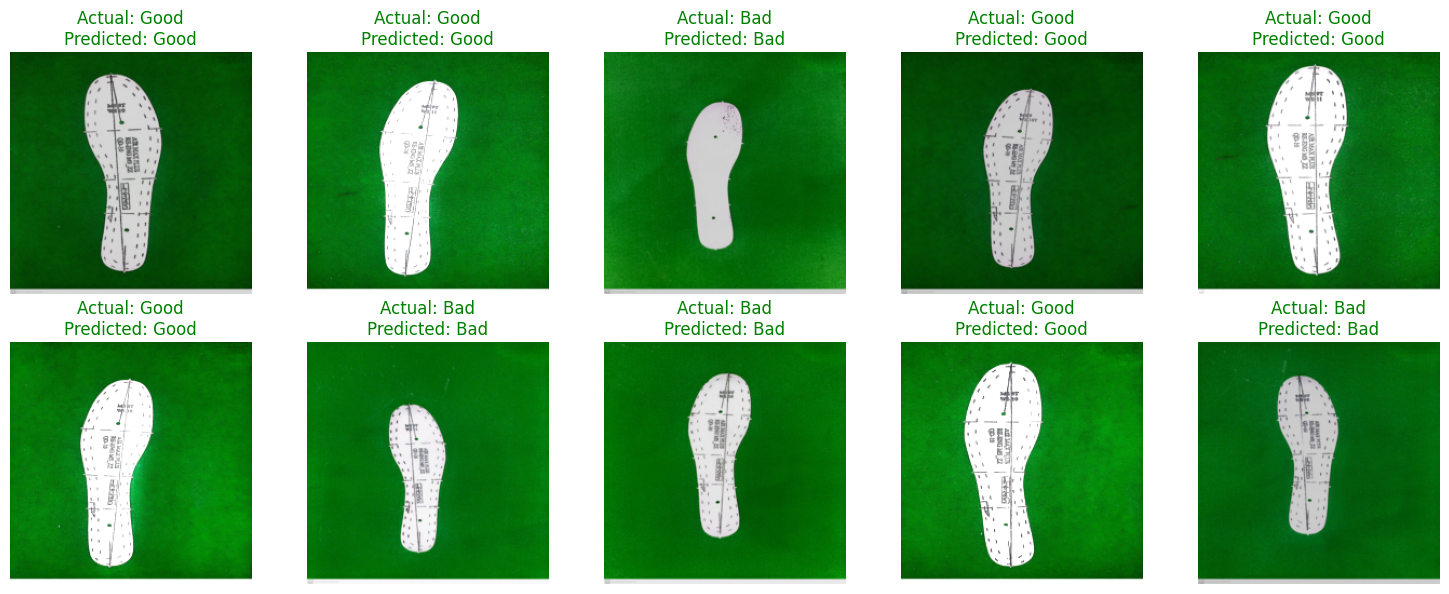

In [ ]:
 def visualize_predictions(model, data_loader, num_images=5):
    model.eval()
    images_shown = 0

    fig, axes = plt.subplots(2, num_images // 2, figsize=(15, 6))
    axes = axes.flatten()

    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds = outputs.argmax(1)

            for i in range(len(images)):
                if images_shown >= num_images:
                    break

                # Konversi Tensor ke Gambar Asli
                image = images[i].cpu().permute(1, 2, 0).numpy()
                image = (image * 0.5) + 0.5  # Denormalisasi

                # Menampilkan gambar
                ax = axes[images_shown]
                ax.imshow(image)
                ax.axis('off')

                # Tampilkan label aktual & prediksi di atas gambar
                actual_label = dataset.classes[labels[i].item()]
                predicted_label = dataset.classes[preds[i].item()]
                color = "green" if actual_label == predicted_label else "red"

                ax.set_title(f"Actual: {actual_label}\nPredicted: {predicted_label}", color=color)

                images_shown += 1

            if images_shown >= num_images:
                break

    plt.tight_layout()
    plt.savefig("prediction_results.png")  # Simpan hasil prediksi
    plt.show()

# 🔥 Panggil fungsi ini setelah evaluasi model
visualize_predictions(model, test_loader, num_images=10)

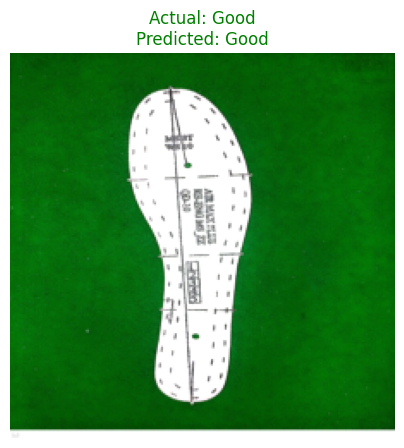

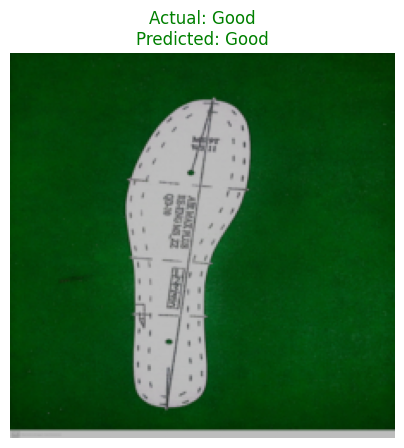

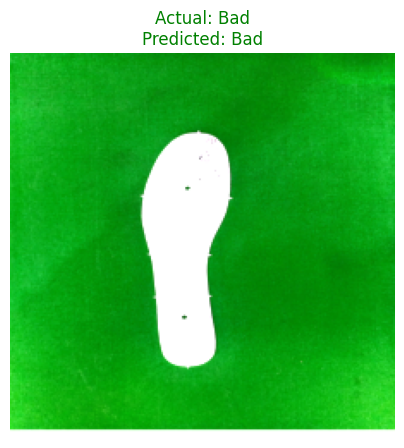

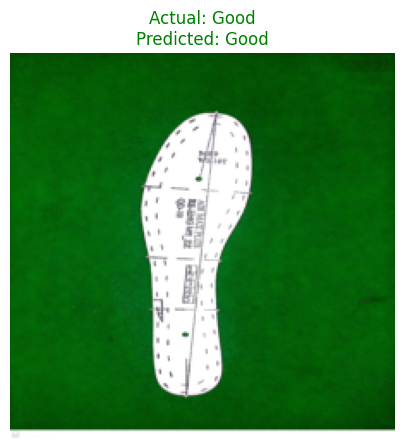

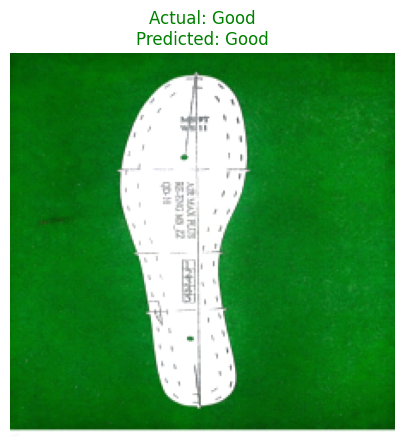

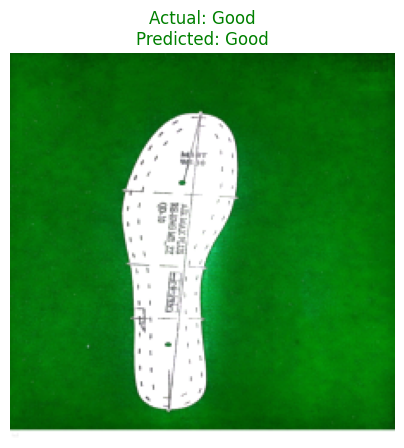

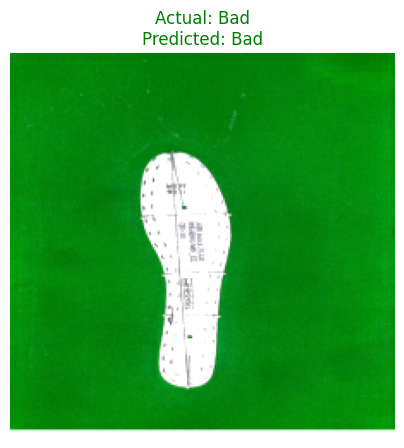

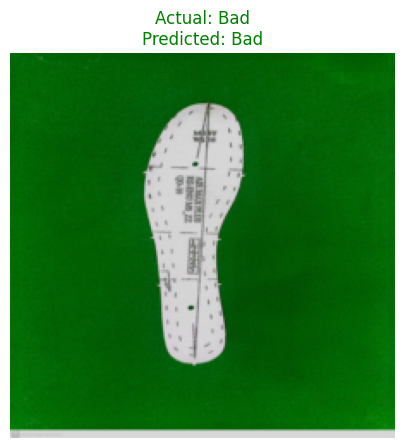

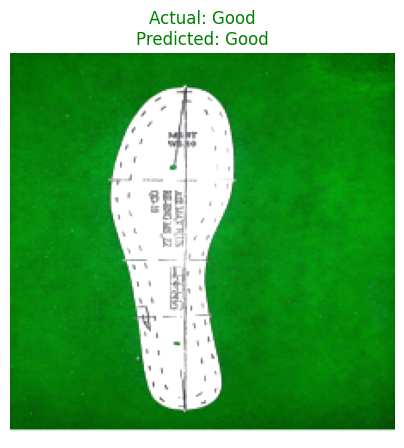

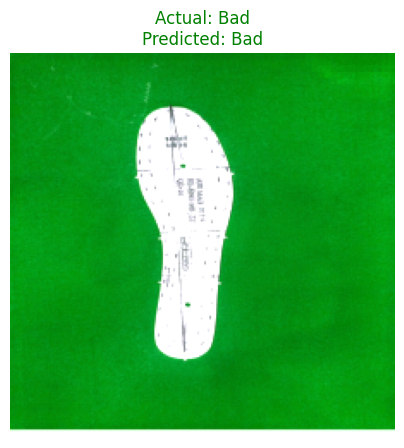

In [ ]:
import torch
import matplotlib.pyplot as plt

def visualize_predictions(model, data_loader, num_images=5):
    model.eval()
    images_shown = 0

    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds = outputs.argmax(1)

            for i in range(len(images)):
                if images_shown >= num_images:
                    break

                # Konversi Tensor ke Gambar Asli
                image = images[i].cpu().permute(1, 2, 0).numpy()
                image = (image * 0.5) + 0.5  # Denormalisasi

                # Mengembalikan gambar ke ukuran semula
                original_size = (224, 224)  # Sesuaikan dengan ukuran asli dataset
                image_resized = cv2.resize(image, original_size)

                # Tampilkan gambar satu per satu
                plt.figure(figsize=(5, 5))
                plt.imshow(image_resized)
                plt.axis('off')

                # Tampilkan label aktual & prediksi
                actual_label = dataset.classes[labels[i].item()]
                predicted_label = dataset.classes[preds[i].item()]
                color = "green" if actual_label == predicted_label else "red"

                plt.title(f"Actual: {actual_label}\nPredicted: {predicted_label}", color=color)

                plt.show()
                images_shown += 1

            if images_shown >= num_images:
                break

# 🔥 Panggil fungsi ini setelah evaluasi model
visualize_predictions(model, test_loader, num_images=10)


Evaluating on Test Set...

Classification Report:
              precision    recall  f1-score   support

         Bad       1.00      0.83      0.91         6
        Good       0.90      1.00      0.95         9

    accuracy                           0.93        15
   macro avg       0.95      0.92      0.93        15
weighted avg       0.94      0.93      0.93        15



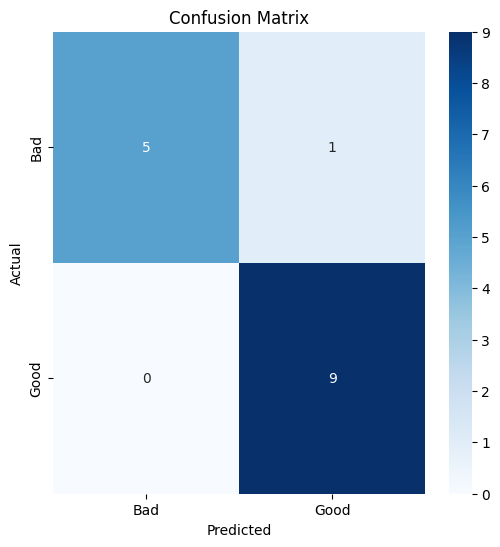

Test Accuracy: 0.9333


In [ ]:
# 5️⃣ Evaluate on Test Set
print("Evaluating on Test Set...")
test_acc = evaluate_model(model, test_loader)
print(f"Test Accuracy: {test_acc:.4f}")

In [ ]:
# 6️⃣ Save the Model
torch.save(model.state_dict(), "vit_strobel_classifier.pth")
print("Model saved successfully!")

Model saved successfully!


In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import gradio as gr
from PIL import Image
from torchvision.models.vision_transformer import vit_b_16

# Load Model (Pastikan model sudah terlatih)
model_path = "/content/vit_strobel_classifier.pth"  # Ganti dengan path model yang sesuai
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 1. Create an instance of the model
model = vit_b_16(pretrained=False)  # Asumsi model menggunakan ViT B-16
model.heads = nn.Linear(768, 2)  # Output 2 kelas: baik & buruk

# 2. Load the state dictionary into the model instance
model.load_state_dict(torch.load(model_path, map_location=device))
model.to(device)
model.eval()

# Transformasi gambar
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Sesuaikan dengan ukuran model
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])  # Sesuai normalisasi saat training
])

# Daftar label kelas (sesuai dataset)
class_labels = ["Bad", "Good"]

# Fungsi Prediksi
def predict(image):
    image = Image.fromarray(image).convert("RGB")  # Konversi gambar
    img_tensor = transform(image).unsqueeze(0).to(device)  # Tambah batch dimension

    # Prediksi
    with torch.no_grad():
        output = model(img_tensor)
        pred_idx = output.argmax(1).item()
        pred_label = class_labels[pred_idx]

    return pred_label

# Buat antarmuka Gradio
iface = gr.Interface(
    fn=predict,
    inputs=gr.Image(type="numpy"),
    outputs="text",
    title="ViT Strobel Classifier",
    description="Upload gambar strobel untuk diklasifikasikan sebagai 'Bad' atau 'Good'."
)

# Jalankan aplikasi
iface.launch(share=True)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
<ipython-input-27-0c19cb84a548>:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the function

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://ea21fa4853fd3307ec.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import gradio as gr
import cv2
import numpy as np
from PIL import Image
from torchvision.models.vision_transformer import vit_b_16
import tempfile

# Load Model (Pastikan model sudah terlatih)
model_path = "/content/vit_strobel_classifier.pth"  # Sesuaikan path model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 1. Create an instance of the model
model = vit_b_16(weights=None)  # Gunakan weights=None untuk menghindari peringatan
model.heads = nn.Linear(768, 2)  # Output 2 kelas: baik & buruk

# 2. Load model weights
model.load_state_dict(torch.load(model_path, map_location=device))  # Bisa tambahkan weights_only=True jika ada error
model.to(device)
model.eval()

# Transformasi gambar
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Sesuaikan dengan ukuran model
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])  # Sesuai normalisasi saat training
])

# Daftar label kelas
class_labels = ["Bad", "Good"]

# Fungsi untuk melakukan prediksi pada setiap frame video
def process_video(video_path):
    cap = cv2.VideoCapture(video_path)
    frame_results = []

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        # Konversi frame ke format yang sesuai
        image = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        img_tensor = transform(image).unsqueeze(0).to(device)

        # Prediksi
        with torch.no_grad():
            output = model(img_tensor)
            pred_idx = output.argmax(1).item()
            pred_label = class_labels[pred_idx]

        # Tambahkan teks label ke frame
        cv2.putText(frame, f"Prediction: {pred_label}", (20, 50),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)

        frame_results.append(frame)

    cap.release()

    # Simpan hasil video
    output_video_path = tempfile.mktemp(suffix=".mp4")
    height, width, _ = frame_results[0].shape
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_video_path, fourcc, 20.0, (width, height))

    for frame in frame_results:
        out.write(frame)

    out.release()
    return output_video_path

# UI Gradio
def predict_video(video):
    output_path = process_video(video)
    return output_path

iface = gr.Interface(
    fn=predict_video,
    inputs=gr.Video(),  # Perbaikan: Hapus argumen `type="mp4"`
    outputs=gr.Video(),
    title="ViT Strobel Classifier (Video)",
    description="Upload video, dan model akan melakukan klasifikasi setiap frame menjadi 'Bad' atau 'Good'."
)

# Jalankan aplikasi
iface.launch(share=True)


<ipython-input-29-0dfc3d93d865>:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device))  # Bisa tambahkan weight

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://ae68901736473fc194.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import gradio as gr
import cv2
import numpy as np
from PIL import Image
from torchvision.models.vision_transformer import vit_b_16
import tempfile
from concurrent.futures import ThreadPoolExecutor

# Load Model
model_path = "/content/vit_strobel_classifier.pth"  # Sesuaikan path model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 1. Create an instance of the model
model = vit_b_16(weights=None)
model.heads = nn.Linear(768, 2)  # Output 2 kelas: baik & buruk

# 2. Load model weights
model.load_state_dict(torch.load(model_path, map_location=device))
model.to(device)
model.eval()

# Gunakan AMP (Automatic Mixed Precision) jika ada GPU
use_amp = device.type == "cuda"

# Transformasi gambar
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Daftar label kelas dan warna bounding box
class_labels = ["Bad", "Good"]
colors = {"Bad": (0, 0, 255), "Good": (0, 255, 0)}  # Red for Bad, Green for Good

# Fungsi untuk membaca video dengan multi-threading
def read_video_frames(video_path):
    cap = cv2.VideoCapture(video_path)
    frames = []

    with ThreadPoolExecutor(max_workers=4) as executor:  # Multi-threading untuk membaca frame
        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break
            frames.append(frame)

    cap.release()
    return frames

# Fungsi untuk menggambar bounding box pada frame
def draw_bounding_box(frame, label):
    height, width, _ = frame.shape
    color = colors[label]

    # Ukuran bounding box (50% dari tinggi dan lebar frame)
    box_x1, box_y1 = int(width * 0.2), int(height * 0.2)
    box_x2, box_y2 = int(width * 0.8), int(height * 0.8)

    # Gambar bounding box
    cv2.rectangle(frame, (box_x1, box_y1), (box_x2, box_y2), color, 3)
    cv2.putText(frame, f"Prediction: {label}", (box_x1, box_y1 - 10),
                cv2.FONT_HERSHEY_SIMPLEX, 1, color, 2, cv2.LINE_AA)

    return frame

# Fungsi untuk melakukan prediksi batch
def process_video(video_path, batch_size=16):
    frames = read_video_frames(video_path)
    frame_results = []

    # Konversi semua frame ke tensor
    image_tensors = []
    for frame in frames:
        image = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        img_tensor = transform(image)
        image_tensors.append(img_tensor)

    # Batched inference
    image_tensors = torch.stack(image_tensors).to(device)
    predictions = []

    with torch.no_grad(), torch.cuda.amp.autocast(enabled=use_amp):  # AMP untuk percepatan di GPU
        for i in range(0, len(image_tensors), batch_size):
            batch = image_tensors[i:i+batch_size]
            output = model(batch)
            preds = output.argmax(1).cpu().numpy()
            predictions.extend(preds)

    # Tambahkan bounding box ke setiap frame
    for frame, pred_idx in zip(frames, predictions):
        pred_label = class_labels[pred_idx]
        frame_with_box = draw_bounding_box(frame, pred_label)
        frame_results.append(frame_with_box)

    # Simpan hasil video dengan codec H264 untuk efisiensi
    output_video_path = tempfile.mktemp(suffix=".mp4")
    height, width, _ = frames[0].shape
    fourcc = cv2.VideoWriter_fourcc(*'H264')  # Gunakan codec H264 agar lebih efisien
    out = cv2.VideoWriter(output_video_path, fourcc, 20.0, (width, height))

    for frame in frame_results:
        out.write(frame)

    out.release()
    return output_video_path

# UI Gradio
def predict_video(video):
    output_path = process_video(video)
    return output_path

iface = gr.Interface(
    fn=predict_video,
    inputs=gr.Video(),
    outputs=gr.Video(),
    title="ViT Strobel Classifier (Video)",
    description="Upload video, dan model akan melakukan klasifikasi setiap frame menjadi 'Bad' atau 'Good' dengan bounding box berwarna merah (Bad) dan hijau (Good)."
)

# Jalankan aplikasi
iface.launch(share=True)


<ipython-input-30-ccd4276653f9>:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device))


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://bc715fb8db5c30faa6.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import gradio as gr
import cv2
import numpy as np
from PIL import Image
from torchvision.models.vision_transformer import vit_b_16
import tempfile

# Load Model (Pastikan model sudah terlatih)
model_path = "/content/vit_strobel_classifier.pth"  # Sesuaikan path model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 1. Create an instance of the model
model = vit_b_16(weights=None)  # Gunakan weights=None untuk menghindari peringatan
model.heads = nn.Linear(768, 2)  # Output 2 kelas: baik & buruk

# 2. Load model weights
model.load_state_dict(torch.load(model_path, map_location=device))  # Bisa tambahkan weights_only=True jika ada error
model.to(device)
model.eval()

# Transformasi gambar
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Sesuaikan dengan ukuran model
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])  # Sesuai normalisasi saat training
])

# Daftar label kelas dan warna bounding box
class_labels = ["Bad", "Good"]
box_colors = {"Bad": (0, 0, 255), "Good": (255, 0, 0)}  # Merah untuk Bad, Biru untuk Good

# Fungsi untuk melakukan prediksi pada setiap frame video
def process_video(video_path):
    cap = cv2.VideoCapture(video_path)
    frame_results = []

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        # Konversi frame ke format yang sesuai
        image = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        img_tensor = transform(image).unsqueeze(0).to(device)

        # Prediksi
        with torch.no_grad():
            output = model(img_tensor)
            pred_idx = output.argmax(1).item()
            pred_label = class_labels[pred_idx]
            color = box_colors[pred_label]

        # Tambahkan teks label ke frame
        cv2.putText(frame, f"Prediction: {pred_label}", (20, 50),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, color, 2, cv2.LINE_AA)

        # Tambahkan bounding box di sekitar frame
        height, width, _ = frame.shape
        cv2.rectangle(frame, (10, 10), (width - 10, height - 10), color, 5)  # Batas luar frame

        frame_results.append(frame)

    cap.release()

    # Simpan hasil video
    output_video_path = tempfile.mktemp(suffix=".mp4")
    height, width, _ = frame_results[0].shape
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_video_path, fourcc, 20.0, (width, height))

    for frame in frame_results:
        out.write(frame)

    out.release()
    return output_video_path

# UI Gradio
def predict_video(video):
    output_path = process_video(video)
    return output_path

iface = gr.Interface(
    fn=predict_video,
    inputs=gr.Video(),  # Perbaikan: Hapus argumen `type="mp4"`
    outputs=gr.Video(),
    title="ViT Strobel Classifier (Video)",
    description="Upload video, dan model akan melakukan klasifikasi setiap frame menjadi 'Bad' atau 'Good'.\n"
                "Bounding box merah = 'Bad', bounding box biru = 'Good'."
)

# Jalankan aplikasi
iface.launch(share=True)


<ipython-input-32-5a97854a958d>:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device))  # Bisa tambahkan weight

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://b0d3a691f3b44be4c7.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [ ]:
# 7️⃣ Inference with GUI & Bounding Box & Counting & Export to Excel
def save_results_to_excel():
    percentage_good = (good_count / total_count) * 100 if total_count > 0 else 0
    percentage_bad = (bad_count / total_count) * 100 if total_count > 0 else 0

    data = {
        "Produk Baik": [good_count],
        "Produk Buruk": [bad_count],
        "Total Produk": [total_count],
        "Persentase Baik (%)": [percentage_good],
        "Persentase Buruk (%)": [percentage_bad]
    }
    df = pd.DataFrame(data)
    df.to_excel("quality_control_results.xlsx", index=False)
    print("Results saved to quality_control_results.xlsx")


In [ ]:
def predict_with_bbox(image):
    model.eval()
    transform_test = transforms.Compose([
        transforms.Resize((384, 384)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])
    image_tensor = transform_test(image).unsqueeze(0).to(device)
    with torch.no_grad():
        output = model(image_tensor)
        pred = output.argmax(1).item()

    label = dataset.classes[pred]

    # Convert PIL image to OpenCV format
    image_cv = np.array(image)
    image_cv = cv2.cvtColor(image_cv, cv2.COLOR_RGB2BGR)
    height, width, _ = image_cv.shape

    # Draw bounding box
    color = (0, 255, 0) if pred == 0 else (0, 0, 255)
    cv2.rectangle(image_cv, (10, 10), (width-10, height-10), color, 5)

    # Update counters
    global good_count, bad_count, total_count
    if pred == 0:
        good_count += 1
    else:
        bad_count += 1
    total_count += 1

    save_results_to_excel()

    return f"Label: {label}, Good: {good_count}, Bad: {bad_count}, Total: {total_count}", image_cv


In [ ]:
good_count, bad_count, total_count = 0, 0, 0
demo = gr.Interface(fn=predict_with_bbox, inputs=gr.Image(), outputs=["text", "image"])
demo.launch()


Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://8450a4a079b47c148f.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [ ]:
# Load Model
model = vit_b_16(pretrained=False)  # Pastikan tidak menggunakan pretrained=True
model.heads = nn.Linear(768, 2)  # Sesuai dengan jumlah kelas
model.load_state_dict(torch.load("vit_strobel_classifier.pth", map_location=device))
model.to(device)
model.eval()


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
<ipython-input-57-a44293a42bfc>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions

VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

In [ ]:
import gradio as gr
import torch
import torch.nn.functional as F
from torchvision import transforms
from PIL import Image
from transformers import ViTForImageClassification, ViTFeatureExtractor

# Load model hanya sekali saat aplikasi dimulai
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_name = "google/vit-base-patch16-224"
feature_extractor = ViTFeatureExtractor.from_pretrained(model_name)
model = ViTForImageClassification.from_pretrained(model_name)
model.to(device)
model.eval()  # Set model ke evaluasi untuk mempercepat inferensi

def preprocess_image(image):
    """Preprocessing gambar tanpa augmentasi"""
    image = image.convert("RGB")  # Pastikan RGB
    inputs = feature_extractor(images=image, return_tensors="pt")
    return inputs["pixel_values"].to(device)

def predict(image):
    """Prediksi kelas gambar menggunakan model ViT"""
    image_tensor = preprocess_image(image)
    with torch.no_grad():  # Matikan grad untuk mempercepat inferensi
        with torch.cuda.amp.autocast():  # Gunakan FP16 jika tersedia
            outputs = model(image_tensor)
            logits = outputs.logits
            probs = F.softmax(logits, dim=1)
            pred_idx = torch.argmax(probs, dim=1).item()

    label = model.config.id2label[pred_idx]
    confidence = probs[0, pred_idx].item()
    return label, confidence

# Gradio Interface
demo = gr.Interface(
    fn=predict,
    inputs=gr.Image(type="pil"),
    outputs=[gr.Text(label="Predicted Class"), gr.Text(label="Confidence")],
    title="ViT Image Classifier",
    description="Upload an image and get a classification result using Vision Transformer."
)

demo.launch()